# Proyecto de pruebas A/B

**Descripción técnica**
- Nombre de la prueba: recommender_system_test
- Grupos: А (control), B (nuevo embudo de pago)
- Fecha de lanzamiento: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Número previsto de participantes de la prueba: 6 000

**Propósito de la prueba:** probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado.
  
**Resultado esperado:** dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.

## 1. Exploración de datos

In [21]:
# Carga de datos 

import pandas as pd
import datetime as dt
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

calendar = pd.read_csv('ab_project_marketing_events_us.csv')
calendar.info()
calendar.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [24]:
new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [32]:
events = pd.read_csv('final_ab_events_upd_us.csv')
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [7]:
participants = pd.read_csv('final_ab_participants_upd_us.csv')
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


## 2. Limpieza de datos

**Preprocesamiento de datos**
- calendar: cuenta con 14 filas, sin datos nulos. cambiar start_dt y finish_dt a formato correcto, separar regiones para facilitar su manejo.
- new_users: 58703 filas sin datos nulos. Cambiar first_date a formato fecha.
- events: 423761 filas, con detalles extra de tan solo 60314. Cambiar el formato de event_dt. Corroborar si los datos que se encuentran en details estan relacionados con en evento purchase.
- participants: 14525 filas, corroborar si estan los datos de los participantes de ambos grupos, y que otro tipo de valor se encuentra en la columna ab_test.



In [ ]:
# DF Calendar

# cambio de formato 
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])

# separación de región EU 

calendar['EU'] = calendar['regions'].str.contains('EU', na=False)
calendar.info()
calendar.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
 4   EU         14 non-null     bool          
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 594.0+ bytes


,name,regions,start_dt,finish_dt,EU
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,True
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,True
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,True
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,True
4,4th of July Promo,N.America,2020-07-04,2020-07-11,False


In [46]:
# DF new_users 

# cambio a formato de fecha 

new_users['first_date'] = pd.to_datetime(new_users['first_date'])
print('usuarios nuevos duplicados:', new_users.duplicated().sum())
new_users.info()

usuarios nuevos duplicados: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [ ]:
# DF events

#cambiar formato de fecha
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()
# corroborar si todos los purchase tienen monto 

mask = events['event_name'] == 'purchase'
all_valid = events.loc[mask, 'details'].notna().all()
print("¿Todos los purchase tienen monto válido?", all_valid)

# duplicados
print('filas duplicadas:', events.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB
¿Todos los purchase tienen monto válido? True
filas duplicadas: 0


In [44]:
# DF Participants
print('Cantidad de participantes para cada grupo:', participants.group.value_counts())

# verificacion de prueba correcta 
print('pruebas incluidas en el df:', participants.ab_test.value_counts())

# Busqueda de inconsistencia de resultados 

print('participantes duplicados:', participants.user_id.duplicated().sum())



Cantidad de participantes para cada grupo: group
A    8214
B    6311
Name: count, dtype: int64
pruebas incluidas en el df: ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64
participantes duplicados: 887


**Observaciones**
Encontramos que nuestros primeros 3 df ya se encuentran listos para su analisis. Sin embargo, el df de participantes de la prueba no se encuentran aún separados por test y encontramos varioas filas duplicadas. Por lo tanto, el siguiente paso será preparar exactamente todo lo que necesitamos para nuestra prueba A/B.

## 3. Separación de datos de los participantes 

### 3.1. Separar eventos en EU para las fechas de ingreso de los usuarios que puedan influir en el comportamiento de los usuarios

In [54]:
# Filtrar EU = True y fechas entre el 7 y 21 de diciembre 2020

start = pd.to_datetime('2020-12-07')
end   = pd.to_datetime('2020-12-21')

events_eu = calendar[
    (calendar['EU'] == True) &
    (calendar['finish_dt'] >= start) &
    (calendar['start_dt'] <= end)
]   
events_eu.info()
events_eu.head()


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       0 non-null      object        
 1   regions    0 non-null      object        
 2   start_dt   0 non-null      datetime64[ns]
 3   finish_dt  0 non-null      datetime64[ns]
 4   EU         0 non-null      bool          
dtypes: bool(1), datetime64[ns](2), object(2)
memory usage: 0.0+ bytes


,name,regions,start_dt,finish_dt,EU


**Nota:** NO hay eventos que se crucen con las fechas de test que alteren el comportamiento de los usuarios. 

### 3.2. Separar usuarios elegibles 

In [55]:
elegible = new_users[
    (new_users['region'] == 'EU') &
    (new_users['first_date'] >= start) &
    (new_users['first_date'] <= end)
]
elegible.info()
elegible.head()

<class 'pandas.core.frame.DataFrame'>
Index: 39466 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     39466 non-null  object        
 1   first_date  39466 non-null  datetime64[ns]
 2   region      39466 non-null  object        
 3   device      39466 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.5+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


### 3.3. Separar participantes de la prueba 

In [ ]:
#filtrar por test

participants_test = (
    participants[participants['ab_test'] == 'recommender_system_test']
    .drop_duplicates()
)
participants_test.info()
participants_test.head()

# Verificamos nuevamente la información 
print('Cantidad de participantes para cada grupo:', participants_test.group.value_counts())

# verificacion de prueba correcta 
print('pruebas incluidas en el df:', participants_test.ab_test.value_counts())

# Busqueda de inconsistencia de resultados 

print('participantes duplicados:', participants_test.user_id.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 3675 entries, 0 to 3674
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3675 non-null   object
 1   group    3675 non-null   object
 2   ab_test  3675 non-null   object
dtypes: object(3)
memory usage: 114.8+ KB
Cantidad de participantes para cada grupo: group
A    2747
B     928
Name: count, dtype: int64
pruebas incluidas en el df: ab_test
recommender_system_test    3675
Name: count, dtype: int64
participantes duplicados: 0


**Observaciones:**
Según lo filtrado en nuestro nuevo df, encontramos que de los 6000 participantes que queremos incluir, solo tenemos 3675 en nuestra prueba. Además los grupos A y B, no se encuentran balanceados.

### 3.4. Cruzar usuarios elegibles con participantes 

In [ ]:
# Identificar los usuarios que si son elegibles 
merged = participants_test.merge(
    elegible[['user_id']], 
    on='user_id', 
    how='left', 
    indicator=True
)

merged['_merge'].value_counts()


_merge
both          3481
left_only      194
right_only       0
Name: count, dtype: int64

In [59]:
# Filtrar los participantes validos
participants_valid = merged[merged['_merge'] == 'both'].drop(columns=['_merge'])
participants_valid.info()
participants_valid.head()
print('Cantidad de participantes para cada grupo:', participants_test.group.value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 3481 entries, 0 to 3480
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  3481 non-null   object
 1   group    3481 non-null   object
 2   ab_test  3481 non-null   object
dtypes: object(3)
memory usage: 108.8+ KB
Cantidad de participantes para cada grupo: group
A    2747
B     928
Name: count, dtype: int64


**Observaciones:**

Ya con limpieza solo 3481 participantes cumplen con las condiciones para ser incluidos en la prueba, los grupos no se encuentran balanceados ya que cantidad de participantes desiguales para cada grupo y esto nos generara sesgos y errores en el análisis.

## 4. Analisis exploratorio de datos

### 4.1. Eventos dentro de los 14 días después de la inscripción 

In [ ]:
# Añadimos fecha de inscripción
df = participants_valid.merge(
    new_users[['user_id', 'first_date']],
    on='user_id',
    how='left'
)

# Unimos los eventos

df_events = df.merge(
    events,
    on='user_id',
    how='left'
)

# Eventos dentro de los 14 días después de la inscripción

df_events['days'] = (
    df_events['event_dt'] - df_events['first_date']
).dt.days

df_events_14 = df_events[df_events['days'].between(0, 14)]
df_events_14.head()


,user_id,group,ab_test,first_date,event_dt,event_name,details,days
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,2020-12-07 14:43:27,purchase,99.99,0
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,2020-12-07 14:43:29,product_cart,NaN,0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,2020-12-07 14:43:27,product_page,NaN,0
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,2020-12-07 14:43:27,login,NaN,0
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20,2020-12-20 15:46:06,product_page,NaN,0


### 4.2. Embudo 

In [65]:
funnel = df_events_14.pivot_table(
    index=['user_id', 'group'],
    columns='event_name',
    values='event_dt',
    aggfunc='count'
).reset_index()

# Convertir a binarios para analisis
for col in ['product_page', 'product_cart', 'purchase']:
    funnel[col] = (funnel[col] > 0).astype(int)

funnel


event_name,user_id,group,login,product_cart,product_page,purchase
0,001064FEAAB631A1,B,3.0,0,1,0
1,0010A1C096941592,A,4.0,0,1,1
2,00341D8401F0F665,A,2.0,0,0,0
3,003DF44D7589BBD4,A,5.0,1,1,0
4,00505E15A9D81546,A,5.0,0,0,0
...,...,...,...,...,...,...
3476,FF5B24BCE4387F86,A,3.0,0,1,1
3477,FF825C1D791989B5,A,4.0,1,0,0
3478,FF8CF7057415EB29,B,1.0,0,1,0
3479,FFAE9489C76F352B,A,3.0,0,1,0


### 4.3. Conversión por grupo

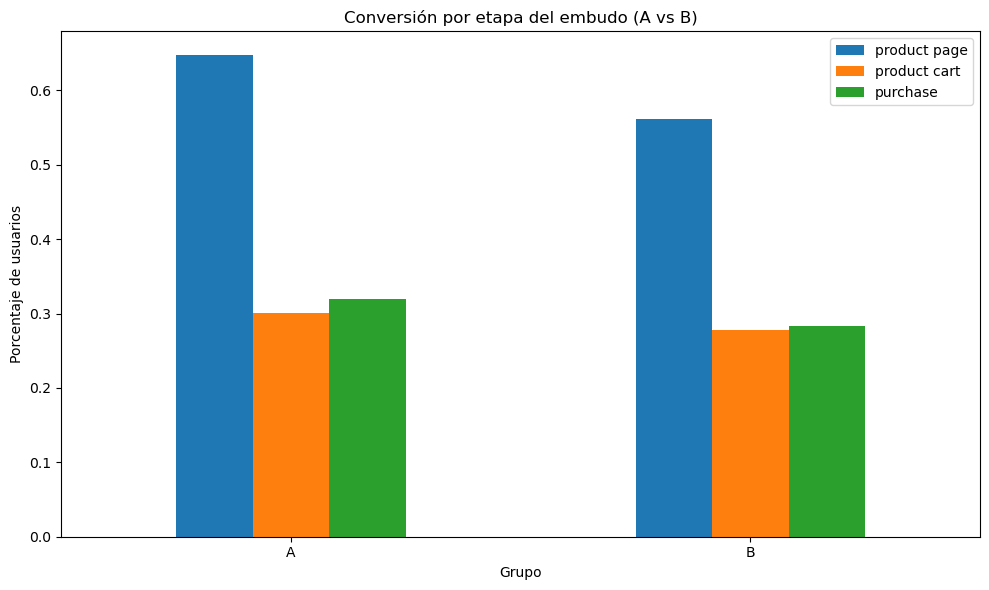

In [74]:
conversion = funnel.groupby('group')[['product_page', 'product_cart', 'purchase']].mean()
conversion


conversion.plot(kind='bar', figsize=(10,6))

plt.title('Conversión por etapa del embudo (A vs B)')
plt.ylabel('Porcentaje de usuarios')
plt.xlabel('Grupo')
plt.xticks(rotation=0)
plt.legend(['product page', 'product cart', 'purchase'])
plt.tight_layout()
plt.show()

### 4.4. Distribución de eventos totales por usuario

        count      mean       std  min  25%  50%  75%   max
group                                                      
A      2604.0  6.673195  3.701340  1.0  4.0  6.0  9.0  24.0
B       877.0  5.450399  3.297829  1.0  3.0  4.0  7.0  24.0


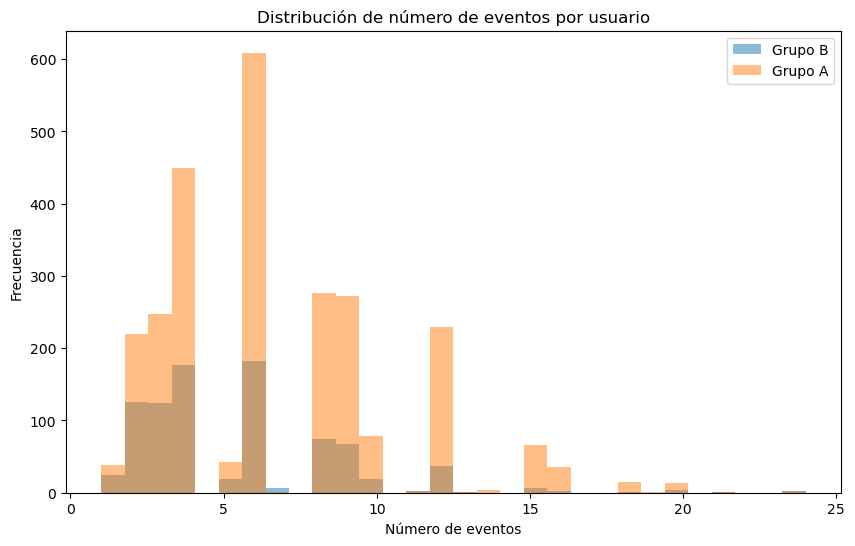

In [86]:
events_per_user = df_events_14.groupby(['user_id', 'group']).size().reset_index(name='n_events')
print(events_per_user.groupby('group')['n_events'].describe())


plt.figure(figsize=(10,6))

for i in events_per_user['group'].unique():
    subset = events_per_user[events_per_user['group'] == i]
    plt.hist(subset['n_events'], bins=30, alpha=0.5, label=f'Grupo {i}')

plt.title('Distribución de número de eventos por usuario')
plt.xlabel('Número de eventos')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


### 4.5. Eventos por dia y grupo 

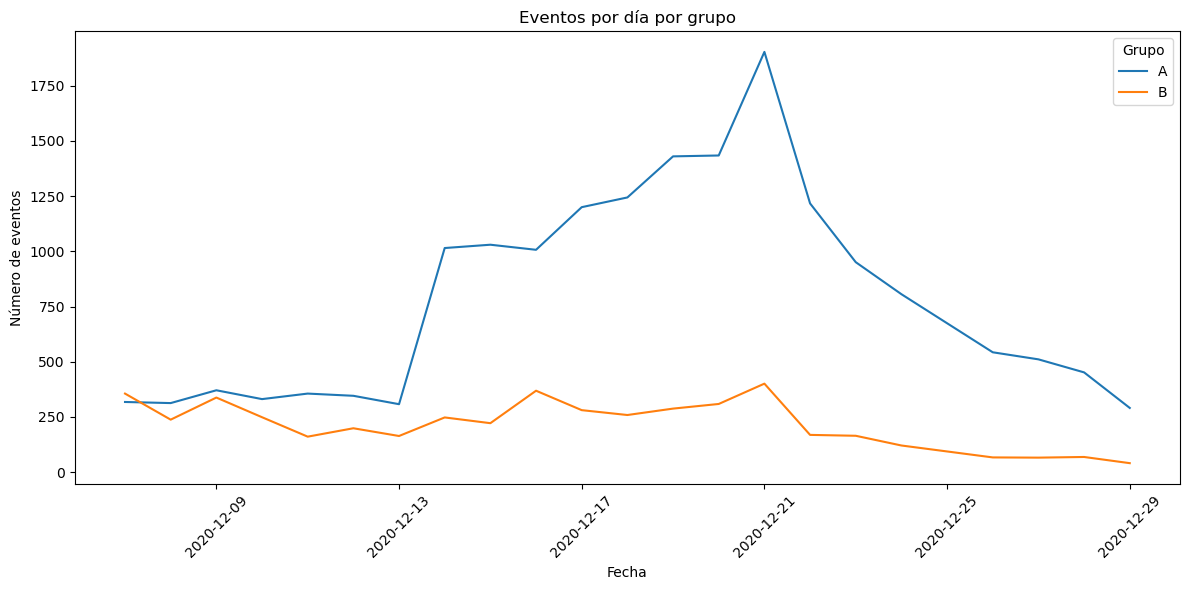

In [85]:
events_by_day_group = df_events_14.groupby(['date', 'group']).size().unstack()

events_by_day_group.plot(kind='line', figsize=(12,6))

plt.title('Eventos por día por grupo')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()

### 4.6. ¿Las muestras son equitativas?

Comparando ambos grupos vemos que: 
- La conversion por grupo son similares.
-  La distribución de los eventos es desigual tanto por cantidad de usuarios como por comportamiento, ya que el grupo A registra más eventos por usuario en promedio y mediana. 
- Hay fechas en las que se disparan los datos del grupo A, por lo tanto aún no se ha encontrado el punto de equilibrio de este grupo, a pesar de tener más participantes, ya que tiene mucha variabilidad.

### 4.7. Limitaciones de la prueba 

- Grupo A casi 3 veces más grande que B: riesgo de sesgo alto, mayor variabilidad en métricas totales, menor potencia estadística del grupo B. 
- Distribución desigual de los eventos: datos mucho más dispersos en el grupo A.
- Picos anómalos en el grupo A en cuanto a la cantidad de eventos: ya conocemos que no hubo campañas adicionales en estas fechas, pero pudo haber algun problema con la aleatorización de los participantes o algún factor que no tenemos contemplado en los datos, lo cual nos generara una inestabilidad temporal en el test. 

## 5. Prueba A/B

**Hipotesis:** La conversión del grupo B tiene al menos un 10% de aumento 

In [ ]:
# tasas de conversion por grupo y por etapa
funnel_rates = funnel.groupby('group')[['login','product_page','product_cart','purchase']].mean()

# identificar la diferencia en % de conver sión en cada grupo 
funnel_rates.loc['diff.'] = (funnel_rates.loc['B'] - funnel_rates.loc['A']) / funnel_rates.loc['A']
funnel_rates

event_name,login,product_page,product_cart,purchase
group,,,,
A,2.959293,0.647081,0.300307,0.319892
B,2.633562,0.562144,0.278221,0.283922
diff.,-0.110071,-0.131263,-0.073545,-0.112444


**Observaciones:** Vemos que hay una diferencia minima entre los dos grupos y sus tasas de conversión para las diferentes etapas, siendo el grupo A el de mayor conversión en todas ellas. 
Ahora realizaremos el test como tal para corroborar exactamente de cuanto es nuestra diferencia porcentual.

### 5.1. Prueba Z 

In [97]:
users_A = funnel[funnel['group'] == 'A']['user_id'].nunique()
users_B = funnel[funnel['group'] == 'B']['user_id'].nunique()

conv_A = funnel[funnel['group'] == 'A']['purchase'].sum()
conv_B = funnel[funnel['group'] == 'B']['purchase'].sum()

print('usuarios de A:', users_A)
print('usuarios de B:', users_B)
print('conversión grupo A:', conv_A) 
print('conversión grupo B:', conv_B)

usuarios de A: 2604
usuarios de B: 877
conversión grupo A: 833
conversión grupo B: 249


In [103]:
# Aplicar z-test

from statsmodels.stats.proportion import proportions_ztest

successes = [conv_A, conv_B]
nobs = [users_A, users_B]

stat, pval = proportions_ztest(successes, nobs)
print('Estadístico z:', stat)
print('p-valor:', pval)

alpha = 0.05

# comparar el valor p con el umbral
if (pval < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


Estadístico z: 1.9906004806163913
p-valor: 0.04652482738393029
Rechazamos la hipótesis nula


**Análisis**
- El grupo B en vez de mostrar una mejora del 10% (valor esperado con el sistema de recomendaciones), muestra una conersion de 11% menos a la hora de la compra y en general peores tasas de conversión en todas las etapas.
- Al tener un p valor menor al alpha, rechazamos la hipotesis nula, lo cual indica que la diferencia entre las tasas de comversión es estadísticamente significtiva y constatamos que el grupo B tiene una peor tasa de conversión en comparación al A, según los participantes y la cantidad de datos que tenemos hasta el momento. 

## Conclusiones 

**1. Analisis de datos:**

Encontramos que los grupos de participantes son desiguales en la prueba, alta variabilidad de datos en el grupo A con picos anómalos. En general, datos para el test con muchas limitaciones y sin cumplir con muchos de los requisitos, entre ellos, el tamaño de la muestra. 

**2. Prueba A/B:** 

Según los datos limitantes utilizados, podemos concluir que hasta el momento el grupo B solo muestra peores cifras en todas las etapas, lo cual fue corroborado estadisticamente con el z-test. 

**3. General:**
 
Es importante destacar qque tantas limitaciones en los datos introduce variabilidad adicional y aumenta el riesgo de sesgos en la estimación del efecto real del experimento.

Por ello, se recomienda mejorar el proceso de recolección y asignación de usuarios, asegurando una captación suficiente y una distribución más equitativa entre las muestras. Asimismo, se podra garantizar un análisis estadístico más limpio, con mejor validez y más confiable.

Sin embargo, con el análisis relaizado hasta el momento, podemos concluir que el nuevo sistema de recomendaciones y embudo de pago no cumple el objetivo estratégico de aumentar conversiones en un 10%.
Además, su rendimiento es significativamente peor, por lo que no se recomiendaría su implementación. 